# Making geo plots with geopandas and matplotlib

We are going to investigate how to:

- draw map using custom shape file
- label and annotate map
- draw map on openstreetmap layer

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

## Reading full-Russia geojson

In [2]:
shapes = gpd.read_file("data/gadm36_RUS_1_fixed.json")
# shapes.to_crs = "+init=epsg:3413 +lon_0=105"
shapes.shape

(85, 2)

## Reading rolling weeks dataset

it contains grouped data for last and previous weeks

In [3]:
rolling_weeks = pd.read_csv("data/covid19ru_rolling_weeks.csv")
rolling_weeks.shape

(170, 5)

## Then we need to calculate some dynamics feature and combine data with shapes

In [4]:
rolling_weeks_sick_new = (
    rolling_weeks.set_index(["region_name", "week"])[["sick_new"]]
    .unstack()
    .reset_index()
)
rolling_weeks_sick_new.head(3)

region_name sick_new         
week                            last previous
0            Алтайский край   1469.0   1509.0
1          Амурская область    934.0    978.0
2     Архангельская область   2150.0   2640.0

In [5]:
rolling_weeks_sick_new.columns = [
    "region_name",
    "sick_new_last_week",
    "sick_new_previous_week",
]
rolling_weeks_sick_new["sick_temp_increase"] = (
    rolling_weeks_sick_new.sick_new_last_week
    / rolling_weeks_sick_new.sick_new_previous_week
    - 1
)

gdf = shapes.merge(rolling_weeks_sick_new)
gdf.head(3)

,region_name,geometry,sick_new_last_week,sick_new_previous_week,sick_temp_increase
0,Республика Адыгея,"POLYGON ((39.65986 43.99760, 39.69266 44.00782...",564.0,633.0,-0.109005
1,Алтайский край,"POLYGON ((82.80364 50.94067, 82.78856 50.94470...",1469.0,1509.0,-0.026508
2,Амурская область,"POLYGON ((131.38809 49.25325, 131.28198 49.250...",934.0,978.0,-0.044990


# Basic plot, highlighting federal subjects depending on new sick dynamics vs previous week

<AxesSubplot:>

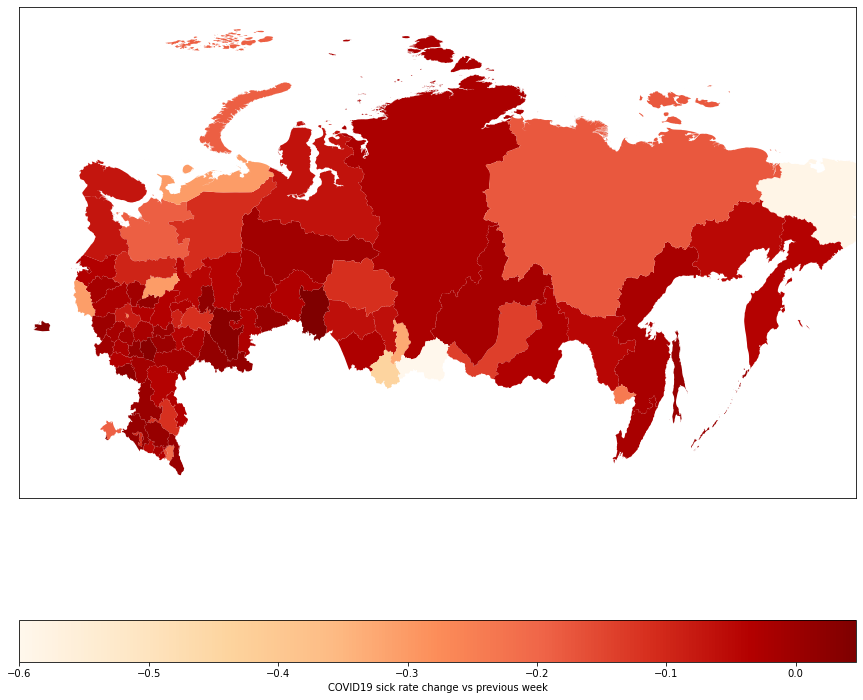

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(17, 177)

gdf.plot(
    ax=ax,
    column="sick_temp_increase",
    legend=True,
    cmap="OrRd",
    legend_kwds={
        "label": "COVID19 sick rate change vs previous week",
        "orientation": "horizontal",
    },
)

## It will be better with some annotations.

Let's generate some data. Say, your employees per federal subject

In [7]:
import numpy as np

employees = rolling_weeks_sick_new[["region_name"]].copy()
employees["emp_count"] = np.random.randint(0, 50, 85)
employees

,region_name,emp_count
0,Алтайский край,38
1,Амурская область,42
2,Архангельская область,49
3,Астраханская область,8
4,Белгородская область,31
...,...,...
80,Чеченская Республика,29
81,Чувашская Республика,9
82,Чукотский автономный округ,5
83,Ямало-Ненецкий автономный округ,46


I know, not very realistic, but it's fine for our example

In [8]:
gdf_with_employees = gdf.merge(employees)
gdf_with_employees.head(3)

,region_name,geometry,sick_new_last_week,sick_new_previous_week,sick_temp_increase,emp_count
0,Республика Адыгея,"POLYGON ((39.65986 43.99760, 39.69266 44.00782...",564.0,633.0,-0.109005,15
1,Алтайский край,"POLYGON ((82.80364 50.94067, 82.78856 50.94470...",1469.0,1509.0,-0.026508,38
2,Амурская область,"POLYGON ((131.38809 49.25325, 131.28198 49.250...",934.0,978.0,-0.044990,42


# So, let's plot. Number can represent number of your employees by region and you can give your recommendations to stay home or not depending on new sick cases dynamics

<ipython-input-9-1a9fdfbeff64>:15: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  lambda x: ax.annotate(


[]

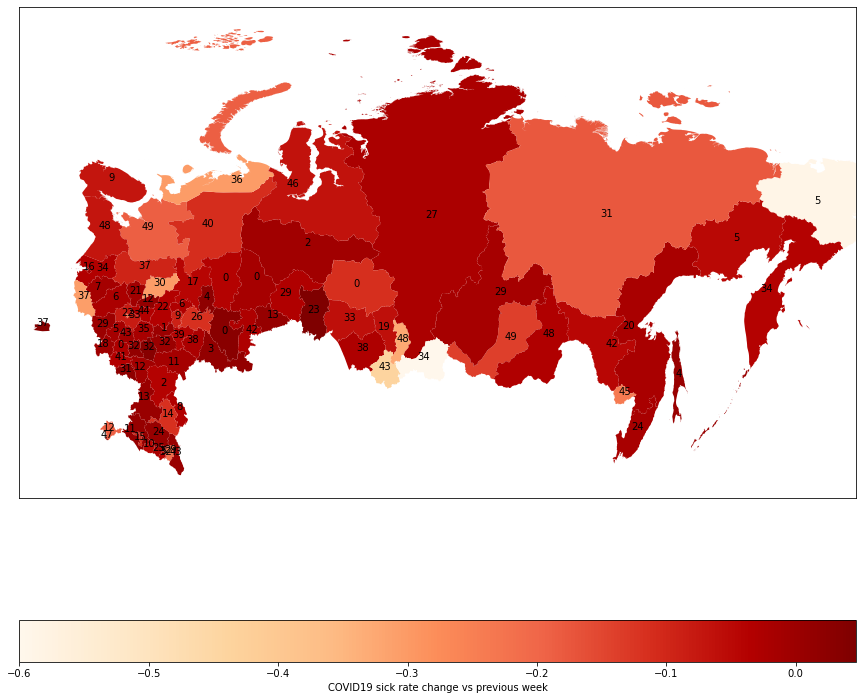

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

gdf_with_employees.plot(
    ax=ax,
    column="sick_temp_increase",
    legend=True,
    cmap="OrRd",
    legend_kwds={
        "label": "COVID19 sick rate change vs previous week",
        "orientation": "horizontal",
    },
)

gdf_with_employees.apply(
    lambda x: ax.annotate(
        s=x.emp_count, xy=x.geometry.representative_point().coords[0], ha="center"
    ),
    axis=1,
)

ax.set_xlim(17, 177)
ax.set_xticks([])
ax.set_yticks([])

## We can do the same with centroids instead of representative points

but representative points works better for russia

# Also we can add OpenStreetMap background to our map

In [10]:
import contextily as ctx

gdf_mercator = gdf_with_employees.to_crs(epsg=3857)

<ipython-input-11-2dd8e9a0fce6>:12: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  lambda x: ax.annotate(


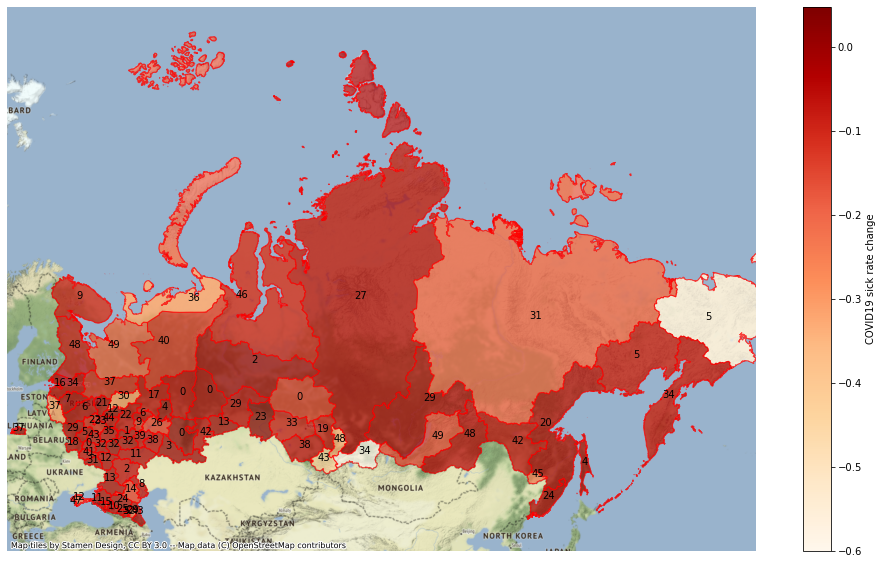

In [11]:
ax = gdf_mercator.plot(
    figsize=(17, 10),
    column="sick_temp_increase",
    cmap="OrRd",
    alpha=0.7,
    edgecolor="r",
    legend=True,
    legend_kwds={"label": "COVID19 sick rate change"},
)

gdf_mercator.apply(
    lambda x: ax.annotate(
        s=x.emp_count, xy=x.geometry.representative_point().coords[0], ha="center"
    ),
    axis=1,
)

ax.set_xlim(0.21 * 1e7, 2.0 * 1e7)
ax.set_axis_off()

ctx.add_basemap(ax)